# Sensitiviy analysis on Jupedsim for GCS

## Background

In this example we're running a simple sensitivity analysis on jupedsim. We're looking at the sensitivity of two variables:
* **force_ped** the strength of the interaction when one pedestrian tries to avoid coming into contact with **another pedestrian**.
* **force_wall** the strength of the interaction when one pedestrain tries to avoid coming into contact with a **wall**.

Jupedsim sets the default values for both of these two variables as 5. In this analysis, we observe the effect of choosing these variables to range in the interval [1, 10].

We look at two model outputs:
* **mean density** within a given zone, averaged across each frame for a period of two minutes.
* **standard deviation of density** within a given zone over the same period of two minutes.

We measure these outputs in two *zones*. 
* **zone 1** a high density area in the data.
* **zone 2** a low density earea in the data.
The figure below shows the population density in the data (not the model) averaged over two mintes and represented as a heatmap. Blue indicates low density, yellow/red is high.

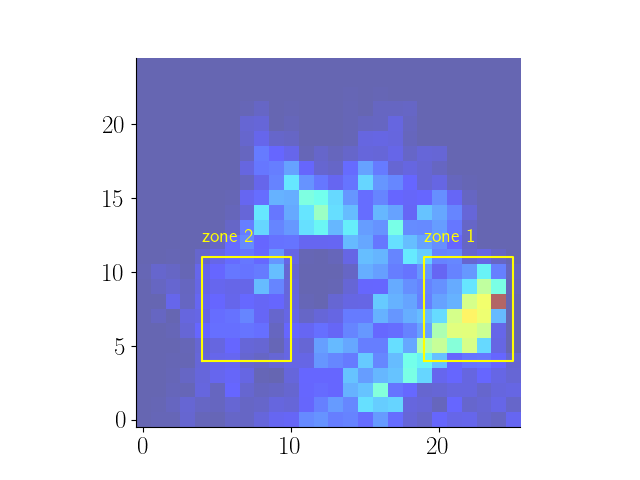

In [1]:
# Plot pre-calculated density map of the GCS data.
# Density is sample once every 30 seconds over 2 minutes.
# The environment is split into a grid with each square at 2m wide.
import os
from PIL import Image

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
image = Image.open(parent_dir + '/data/figures/average_density_zones.png')
display(image)

The model has already been run in advance with different parameters.
First some code to set up plotting the results:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from SALib.analyze import sobol


import sa


m, sigma = 0, 1
zone1, zone2 = 0, 1
force_ped, force_wall = 0, 1

labels = {'output': ('mean', 'std dev'),
          'zone': ('zone 1', 'zone 2'),
          'var': ('force ped', 'force wall')}

# get the parameters tested
param_values = sa.get_param_values()
# results from those parameters
sim_results = (sa.get_report_results(1),
               sa.get_report_results(2))


def plot_data_density():
    """ Plot pre-calculated density map of the GCS data.
        Density is sample once every 30 seconds over 2 minutes.
        The environment is split into a grid with each square at 2m wide."""
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    image = Image.open(parent_dir + '/data/figures/average_density_zones.png')
    display(image)

def normalise(x, range1, range2):
    """ Rescale x from range1 to range2."""
    delta1 = range1[1] - range1[0]
    delta2 = range2[1] - range2[0]
    return (delta2 * (x - range1[0]) / delta1) + range2[0]

def get_colours(output):
    """ Get colours for heatmap"""
    # normalise results to colour map (0, 255)
    min_x = min(output)
    max_x = max(output)
    # must make density an int for the colourmap to work correctly
    output = [int(normalise(x, (min_x, max_x), (0, 255))) for x in output]
    return [cm.jet(d) for d in output]


def plot_sim_results_one_var(zone_no, var, output, ax):
    """ Plot the simulation output, given the model parameter var, for zone zone_no"""
    ax.scatter(param_values[:,var], sim_results[zone_no][output])
    ax.set_xlabel(labels['var'][var])
    ax.set_ylabel(labels['output'][output])
    ax.set_title(labels['zone'][zone_no])
    

def plot_sim_results_two_var(output):
    """ Plot the simulation output, given the both model parameters for each zone."""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    xi = force_ped
    yi = force_wall
    all_colours = get_colours(np.array((sim_results[zone1][output],
                                        sim_results[zone2][output])).flatten())
    for zone_no in (zone1, zone2):
        ax[zone_no].scatter(param_values[:,xi],
                         param_values[:,yi],
                         c=all_colours[300*zone_no: 300*(zone_no+1)])
        ax[zone_no].set_xlabel(labels['var'][xi])
        ax[zone_no].set_ylabel(labels['var'][yi])
        ax[zone_no].set_title(labels['zone'][zone_no])


### Force ped

First we look at the effect of force_ped on the mean population density in each zone. The figure below shows the results. Note that other variable force_wall is not constant in the plots. Each point in the plot shows the value of force_ped given to the model and the resulting average population density in that zone. The value of force_wall may have been any value in the range [1, 10].

The plots show that in zone 1, if force ped is approximately 5, the population density is at its highest. For values lower or higher than 5, the population density decreases.
However, for zone 2, this peak appears when force_ped is around 3.

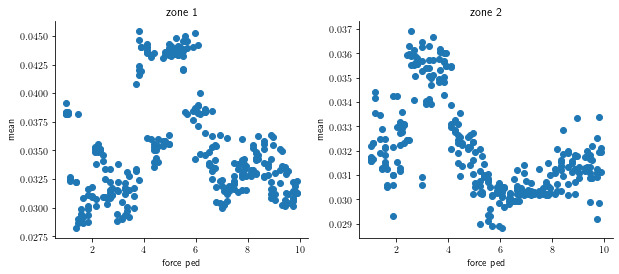

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_sim_results_one_var(zone1, force_ped, m, ax[0])
plot_sim_results_one_var(zone2, force_ped, m, ax[1])

Next, we look at how force_ped effects the standard deviation of population density over time.
In zone 1, the deviation is highest when force_ped is around 4, and decreases as the force_ped is chosen to be lower or higher than 4.
In zone 2, the standard deviation of population density varies (is uncertain) when force_ped is low, but becomes more predictable (certain) as force_ped increase.

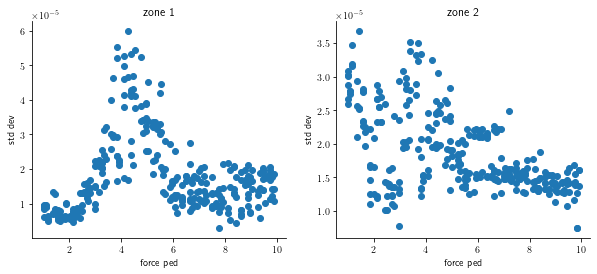

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_sim_results_one_var(zone1, force_ped, sigma, ax[0])
plot_sim_results_one_var(zone2, force_ped, sigma, ax[1])

### Force wall

Next, we look at the effect of force_wall on the mean density in each zone. The figure below shows the results. Note, again, that for each scatter point, the x axis indicates the value of force_wall, but the value of force_ped is not shown and may have been any value in the range [1, 10].

The plots indicate that force_wall has no effect on pedestrian density in either zone.

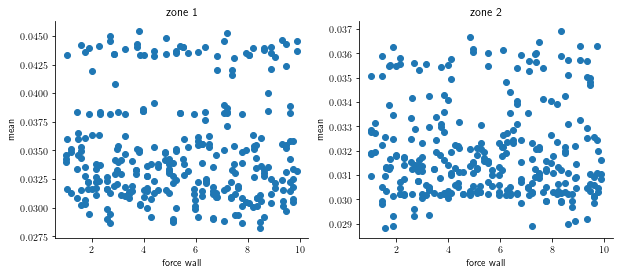

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_sim_results_one_var(zone1, force_wall, m, ax[0])
plot_sim_results_one_var(zone2, force_wall, m, ax[1])

Next, we look at the effect of force_wall on the standard deviation of population density over time. These plots also indicate that force_wall has no effect on the variance of pedestrian density in either zone.

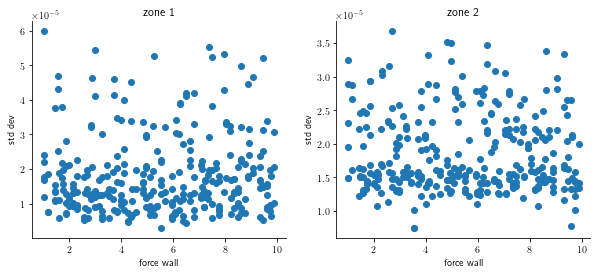

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_sim_results_one_var(zone1, force_wall, sigma, ax[0])
plot_sim_results_one_var(zone2, force_wall, sigma, ax[1])

### Interactions

The drawback of the above two figures is they don't show the interactions between force_ped and force_wall. This we show next.

The figure below show the two input parameters given to the model: force_ped (x-axis) and force_wall (y-axis). Each point in the plot represents one model run with this parameter pair. The colour indicates the mean population density in each zone. Blue indicates low density, red is higher.

*Note that the colours are scaled to the model outputs. So red does not necessarily mean the area was dense. Instead, it means this is the most dense either zone became at any point across all model runs.*

The two plots for the two zones share the same heatmap scale. That is, a given colour indicates the same density in both plots. It is clear that zone 1 has a much higher density than zone 2 (as expected given that data). We can see that as we move along the x-axis, the colours change. However, as we move along the y-axis the colours don't noticeably differ.

Therefore, there is no strong interaction between the two parameters. Only force ped has an effect on the model.

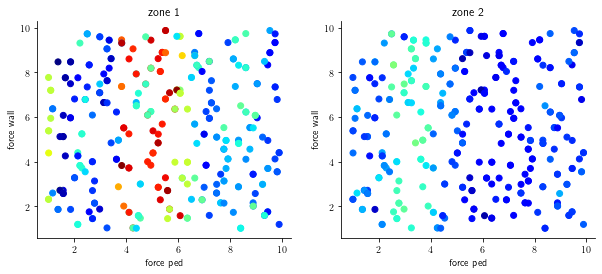

In [7]:
plot_sim_results_two_var(m)

Below, we show the same plots for the effect on the standard deviation of population density. 
Again, colours change as we move along the x-axis for zone 1, but not as we move along the y-axis.
For zone 2, there are some lighter shades where force ped < 6, but the change does not appear to be strong. There also appears to be no change along the y axis.

Once again, there is no interaction effect, and only force ped as affected the model output.

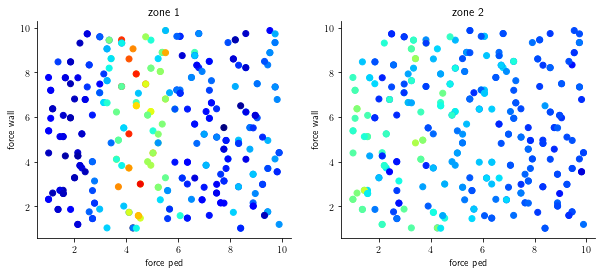

In [8]:
plot_sim_results_two_var(sigma)

## Overview

### Results
* The parameter force_ped has a noticeable effect on pedestrian density in each zone.
* Force_ped has a stronger effect in zone 1 than zone 2.
* The two zones are effected different by force_ped
    * force_ped has the strongest effect in zone 1 in the range [4, 6].
    * force_ped has the strongest effect in zone 2 in the range [2, 4].
* Force_wall has no noticeable effect.


### Limitations
* Ensemble variance was not taken into account.


### Future work
* Consider other parameters that may have a strong effect. For example:
 * the distance at which force_ped comes into effect.
 * the mean desired speed of pedestrains
 * the variance in the desired speed of pedestrains